# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
from lakemodel_function import lake_problem

model = Model("lake", function=lake_problem)
model.time_horizon = 100

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),  # the lake’s natural removal rate
    RealParameter("q", 2.0, 4.5),   # the lake’s natural recycling rate
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]
# set levers, one for each time step
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(model.time_horizon)]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
]

In [3]:
from ema_workbench import MultiprocessingEvaluator

n_scenarios = 250
n_policies = 10

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, n_policies)

100%|██████████████████████████████████████| 2500/2500 [00:26<00:00, 95.43it/s]


In [4]:
experiments = experiments.drop([f"l{i}" for i in range(model.time_horizon)], axis=1)
experiments.head()

,b,delta,mean,q,stdev,scenario,policy,model
0,0.392937,0.967439,0.032539,2.096623,0.004150,10,0,lake
1,0.212692,0.965724,0.036227,2.403664,0.003676,11,0,lake
2,0.237285,0.944172,0.029213,2.279848,0.001275,12,0,lake
3,0.403455,0.940585,0.023855,3.764934,0.003887,13,0,lake
4,0.270382,0.966097,0.027373,2.386177,0.001056,14,0,lake


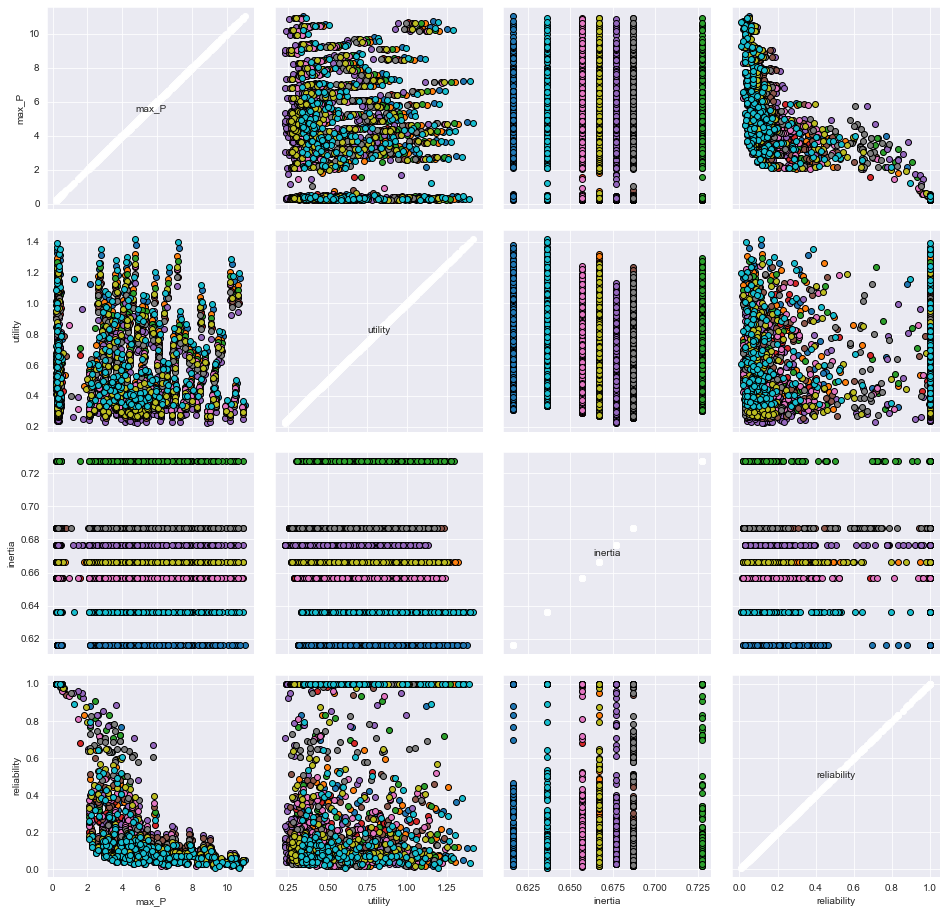

In [5]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(16, 16)
plt.show()

%matplotlib [-l] [gui]

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

%matplotlib inline

In [6]:
new_columns = {"b": "removal_rate", "q": "recycling_rate"}
experiments = experiments.rename(columns=new_columns)

In [7]:
experiments

,removal_rate,delta,mean,recycling_rate,stdev,scenario,policy,model
0,0.392937,0.967439,0.032539,2.096623,0.004150,10,0,lake
1,0.212692,0.965724,0.036227,2.403664,0.003676,11,0,lake
2,0.237285,0.944172,0.029213,2.279848,0.001275,12,0,lake
3,0.403455,0.940585,0.023855,3.764934,0.003887,13,0,lake
4,0.270382,0.966097,0.027373,2.386177,0.001056,14,0,lake
...,...,...,...,...,...,...,...,...
2495,0.289913,0.942663,0.049842,2.114173,0.004438,255,9,lake
2496,0.430194,0.979900,0.024883,3.287862,0.003522,256,9,lake
2497,0.245771,0.951248,0.030239,2.767649,0.004442,257,9,lake
2498,0.166179,0.952017,0.041436,2.106034,0.004201,258,9,lake


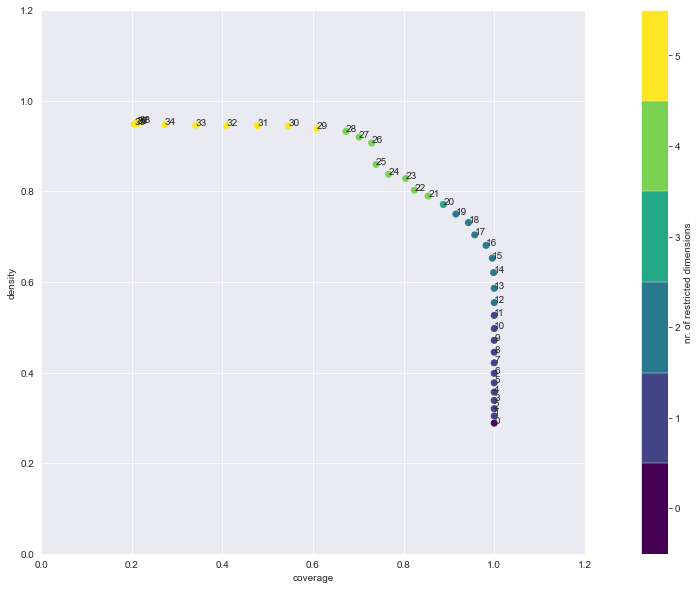

In [8]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes["max_P"] < 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.peeling_trajectory["id"] = box1.peeling_trajectory["id"].astype(int).astype(str)

fig = box1.show_tradeoff(annotated=True)
fig.set_size_inches((20,10))
#fig.savefig("peeling-trajectory-annotated.png", dpi=200, bbox_inches='tight')

In [9]:
points = [11, 19, 26]

coverage         1.0
density     0.526277
id                11
mass           0.548
mean        0.526277
res_dim            1
Name: 11, dtype: object

                box 11                                         
                   min       max                      qp values
removal_rate  0.257928  0.449063  [7.536790846760435e-76, -1.0]

coverage    0.915395
density         0.75
id                19
mass           0.352
mean            0.75
res_dim            2
Name: 19, dtype: object

                  box 19                                          
                     min       max                       qp values
removal_rate    0.284736  0.449063  [1.540235064295653e-119, -1.0]
recycling_rate  2.562776  4.499268   [9.814803319298487e-29, -1.0]

coverage    0.729542
density     0.906897
id                26
mass           0.232
mean        0.906897
res_dim            4
Name: 26, dtype: object

                  box 26                                          
                  

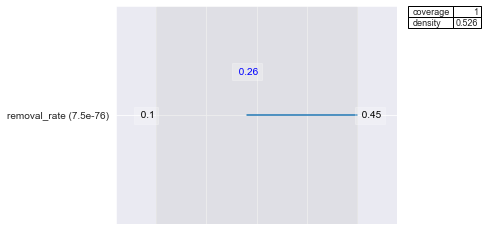

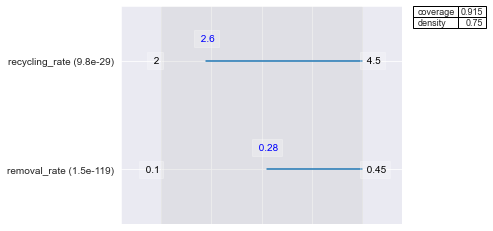

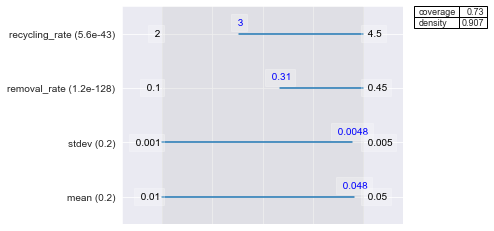

In [10]:
for i, p in enumerate(points):
    box1.inspect(p)
    box1.inspect(p, style="graph")
plt.show()

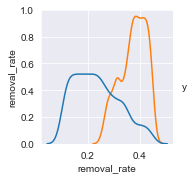

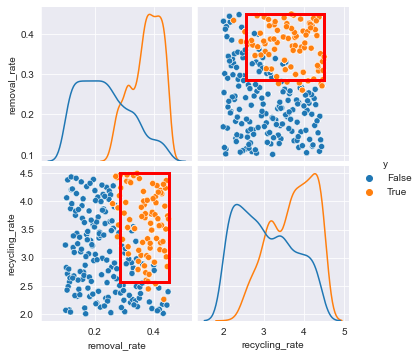

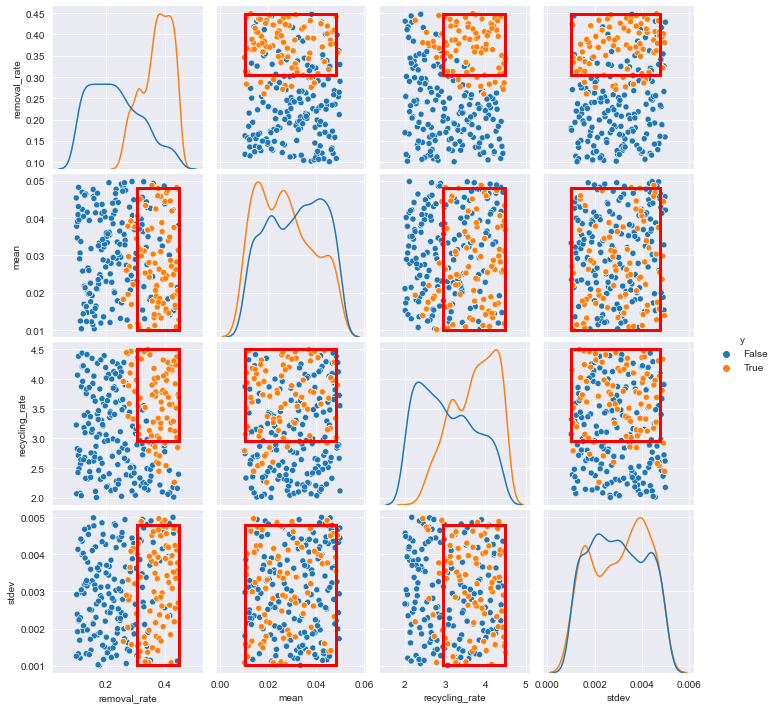

In [11]:
for p in points:
    box1.show_pairs_scatter(p)

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [12]:
from ema_workbench.analysis import dimensional_stacking

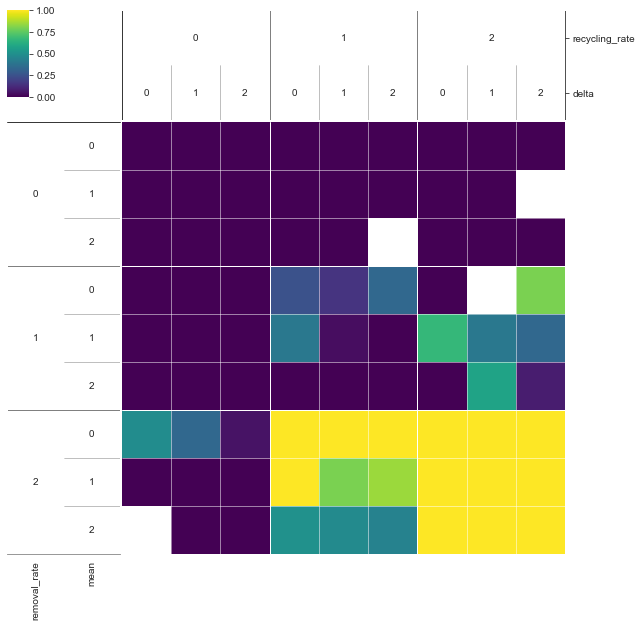

In [20]:
figure1 = dimensional_stacking.create_pivot_plot(x, y, nr_levels=2, nbins=3)